In [9]:
# NOTE: KEEPING NUMBERS 

import numpy as np
import pandas as pd
import re
import sklearn.metrics.pairwise as smp
import seaborn as sns 
import matplotlib.pyplot as plt
from bgg_functions import *

In [2]:
bggdata_df = pd.read_pickle('datasources/BGG_FINAL.pkl')

In [3]:
bggdata_df.columns

Index(['game_rank', 'geek_rating', 'avg_rating', 'num_raters', 'game_name',
       'game_year', 'bgg_url', 'reimpl0', 'reimpl0href', 'ranks', 'avgrating',
       'titleinfo', 'gameplayinfo', 'gamecredits', 'ftr_title', 'ftr_descr',
       'gamedscription', 'rnkoverall', 'rnkthematic', 'rnkstrategy',
       'shortsummary', 'numplayersmin', 'numplayersmax', 'gamedurmin',
       'gamedurmax', 'agemin', 'gameweight', 'designer', 'artist', 'publisher',
       'gametype', 'gamecategory', 'gamemechanisms', 'gamefamily', 'rnkwar',
       'rnkcustomizable', 'rnkfamily', 'rnkabstract', 'rnkparty',
       'rnkchildren's', 'rnkamiga', 'rnkcommodore64', 'rnkarcade',
       'rnkatariST'],
      dtype='object')

In [4]:
bggdata_df.shape

(18900, 44)

### Get game word2vec

In [5]:
from gensim.models import Word2Vec
bgg_model = Word2Vec.load('datasources/bgg_w2v_model.bin')
words = list(bgg_model.wv.vocab)
print(words[:11])

['gloomhaven', 'is', 'a', 'game', 'of', 'tactical', 'combat', 'in', 'persistent', 'world', 'shifting']


# Create vectors for all boardgames

In [20]:
testdf = pd.DataFrame({'desc':bggdata_df.loc[[0, 126, 151],'gamedscription']})
testdf['desc2']=[ ' '.join(sanitize_text(x)) for x in testdf['desc']]
testdf.shape

(3, 2)

In [23]:
testdf

,desc,desc2
0,Gloomhaven is a game of Euro-inspired tactical...,gloomhaven is a game of euroinspired tactical ...
126,You are one of the two most powerful traders i...,you are one of the two most powerful trader in...
151,Splendor is a game of chip-collecting and card...,splendor is a game of chipcollecting and card ...


## Get average vectors for each game description *EDIT* Modified to use description2vector

In [21]:
gamedocvects_df = pd.DataFrame({})

for currdoc in testdf['desc2']:
    numw = len(currdoc)
    docvect_df = pd.DataFrame({})
    for w in range(0,numw): # Over all words in the doc
        if currdoc[w] in words:
            docvect_df = pd.concat((docvect_df,pd.DataFrame(bgg_model.wv[currdoc[w]])),axis=1)
    gamedocvects_df = pd.concat((gamedocvects_df,docvect_df.mean(axis=1)),axis=1)
    

In [24]:
gamedocvects_df.shape

(100, 3)

### Sanity check

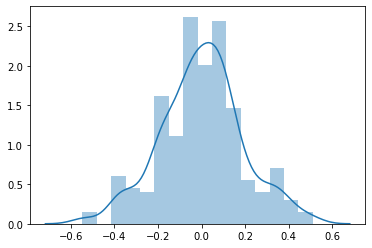

In [25]:
sns.distplot(np.ravel(gamedocvects_df))

In [26]:
gamedocvects = np.array(gamedocvects_df).T # vectors, 1 per document: each ROW is a game
gamesimilarities = smp.cosine_similarity(gamedocvects)
gamesimilarities_df = pd.DataFrame(gamesimilarities,columns=list(bggdata_df.loc[testdf.index,'game_name']),index=list(bggdata_df.loc[testdf.index,'game_name']))

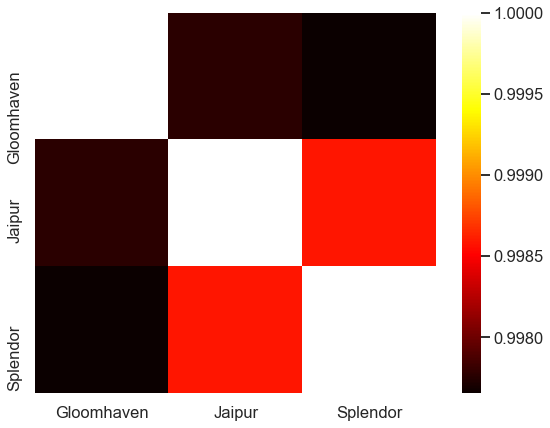

In [27]:
sns.set(context='talk')
f,a = plt.subplots(1,1,figsize=(9,7))
ax = sns.heatmap(gamesimilarities_df, cmap='hot')

# Get similarities for ALL GAMES 
### Select only games with desc lens >N
### N >= 200

In [28]:
bggdata_df.shape

(18900, 44)

In [29]:
bggdata_df.columns

Index(['game_rank', 'geek_rating', 'avg_rating', 'num_raters', 'game_name',
       'game_year', 'bgg_url', 'reimpl0', 'reimpl0href', 'ranks', 'avgrating',
       'titleinfo', 'gameplayinfo', 'gamecredits', 'ftr_title', 'ftr_descr',
       'gamedscription', 'rnkoverall', 'rnkthematic', 'rnkstrategy',
       'shortsummary', 'numplayersmin', 'numplayersmax', 'gamedurmin',
       'gamedurmax', 'agemin', 'gameweight', 'designer', 'artist', 'publisher',
       'gametype', 'gamecategory', 'gamemechanisms', 'gamefamily', 'rnkwar',
       'rnkcustomizable', 'rnkfamily', 'rnkabstract', 'rnkparty',
       'rnkchildren's', 'rnkamiga', 'rnkcommodore64', 'rnkarcade',
       'rnkatariST'],
      dtype='object')

In [30]:
##MO: UPDATE, Jun 8: include game_rank as real index
N=200 # DESC LENS AT LEAST THIS LONG (CHARS)
allgamesdesc_df = bggdata_df[['game_rank','game_name','gamedscription']]
#allgamesdesc_df = pd.DataFrame({'idx':bggdata_df.index,'game_rank':bggdata_df['game_rank'],'gamename':bggdata_df['game_name'],'desc':bggdata_df['gamedscription']})
allgamesdesc_df = allgamesdesc_df[allgamesdesc_df['gamedscription'].str.len()>=N]

In [34]:
allgamesdesc_df.shape

(18561, 4)

In [38]:
### THIS IS MAIN CELL THAT TAKES FOREVER

In [ ]:
# OLD:
#dum_df = sanitize_text(pd.DataFrame(allgamesdesc_df['gamedscription']),'gamedscription','desc_clean')
#allgamesdesc_df['desc_clean'] = dum_df['desc_clean']

In [36]:
##allgamesdesc_df.to_pickle('sanitized_game_descriptions_master.pkl')

In [37]:
allgamesdesc_df.shape

(18561, 4)

In [39]:
allgamesdesc_df.head(3)

,game_rank,game_name,gamedscription,desc_clean
0,1,Gloomhaven,Gloomhaven is a game of Euro-inspired tactical...,gloomhaven is a game of euroinspired tactical ...
1,2,Pandemic Legacy: Season 1,Pandemic Legacy is a co-operative campaign gam...,pandemic legacy is a cooperative campaign game...
2,3,Terraforming Mars,"In the 2400s, mankind begins to terraform the ...",in the 2400s mankind begin to terraform the pl...


In [40]:
allgamesdesc_df.tail(3)

,game_rank,game_name,gamedscription,desc_clean
18897,18898,Mad Gab,From the game box:\nRead a group of simple wor...,from the game box read a group of simple word ...
18898,18899,Titanic: The Board Game,"""Gossip with other passengers, receive telegra...",gossip with other passenger receive telegram a...
18899,18900,Tenzi,Every player gets 10 dice.\nThe object of the ...,every player get 10 dice the object of the gam...


In [41]:
allgamedocvects_df = pd.DataFrame({})

for currdoc in allgamesdesc_df['desc_clean']:
    numw = len(currdoc)
    docvect_df = pd.DataFrame({})
    for w in range(0,numw): # Over all words in the doc
        if currdoc[w] in words:
            docvect_df = pd.concat((docvect_df,pd.DataFrame(bgg_model.wv[currdoc[w]])),axis=1)
    allgamedocvects_df = pd.concat((allgamedocvects_df,docvect_df.mean(axis=1)),axis=1)
    

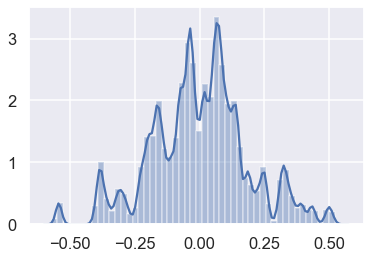

In [42]:
sns.distplot(np.ravel(allgamedocvects_df))

In [43]:
allgamedocvects = np.array(allgamedocvects_df).T # Transpose so each ROW is a game.
print('Each ROW is a game; shape of matrix is: {}'.format(allgamedocvects.shape))

Each ROW is a game; shape of matrix is: (18561, 100)


In [44]:
allgamedocvects_array = np.asarray(allgamedocvects)
np.savez_compressed('allgamedocvects_v2.npy', allgamedocvects_array)

In [ ]:
allgamesimilarities = smp.cosine_similarity(allgamedocvects)

In [ ]:
allgamesimilarities.shape

In [ ]:
allgamesimilarities_df = pd.DataFrame(allgamesimilarities,columns=list(allgamesdesc_df['gamename']),index=list(allgamesdesc_df['gamename']))

In [ ]:
import pandas_profiling

In [ ]:
# SAVE DATA
#allgamesimilarities_df.to_csv('BGG_GameSimilarityMatrix.csv')
#allgamesimilarities_df.to_pickle('BGG_GameSimilarityMatrixP4.pkl',protocol=4)

In [47]:
finalgamelist_df = pd.DataFrame({'idx':allgamesdesc_df.index,'game_rank':np.array(list(allgamesdesc_df['game_rank'].astype('int32'))),'game_name':np.array(list(allgamesdesc_df['game_name']))})
finalgamelist_df.head()

,idx,game_rank,game_name
0,0,1,Gloomhaven
1,1,2,Pandemic Legacy: Season 1
2,2,3,Terraforming Mars
3,3,4,Brass: Birmingham
4,4,5,Through the Ages: A New Story of Civilization


In [48]:
finalgamelist_df.tail()

,idx,game_rank,game_name
18556,18895,18896,Buckaroo!
18557,18896,18897,Snap
18558,18897,18898,Mad Gab
18559,18898,18899,Titanic: The Board Game
18560,18899,18900,Tenzi


In [49]:
finalgamelist_df.shape

(18561, 3)

In [50]:
# SAVE DATA
finalgamelist_df.to_pickle('datasources/BGG_GameSimilarityKey.pkl')
#finalgamelist_df.to_csv('BGG_GameSimilarityKey.csv')

In [ ]:
finalgamelist_df.tail()

In [ ]:
allgamesdesc_df

## Test some random sets

In [ ]:
allgamesimilarities_df.shape

In [ ]:
ii = np.append(0,np.random.randint(0,18560,6))

In [ ]:
ax = sns.heatmap(allgamesimilarities_df.iloc[ii,ii], cmap='hot')

In [ ]:
list(allgamesimilarities_df.index[ii])

In [ ]:
finalgamelist_df.loc[ii,'gamename']

# Find game most similar to...

In [51]:
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

In [52]:
def get_similar_games(mygamename):
    gamename_matchlist = [fuzz.token_sort_ratio(x,mygamename) for x in finalgamelist_df['gamename']]
    possiblegame_idx  = [i for i, x in enumerate(gamename_matchlist) if x == max(gamename_matchlist)]
    possiblegame_idx = possiblegame_idx[0] # Get first, make it number
    possiblegame_name = list(finalgamelist_df.loc[finalgamelist_df['idx']==possiblegame_idx,'gamename'])[0]
    print('Best match: {}'.format(possiblegame_name))

    mygamevect = list(allgamesimilarities_df.loc[:,possiblegame_name])
    mygamevect_df = pd.DataFrame({'gamename':allgamesimilarities_df.index,'cosinesimilarity':mygamevect})
    mygamevect_df.sort_values(by='cosinesimilarity',inplace=True,ascending=False)
    
    return mygamevect_df

In [ ]:
mygamename='elfenland'
mygamevect_df = get_similar_games(mygamename)
mygamevect_df.head(11)


# ROUGHWORK

In [56]:
dum2 = allgamesdesc_df.loc[0,'desc_clean']

In [57]:
dum2

'gloomhaven is a game of euroinspired tactical combat in a persistent world of shifting motif player will take on the role of a wandering adventurer with their own special set of skill and their own reason for traveling to this dark corner of the world player must work together out of necessity to clear out menacing dungeon and forgotten ruin in the process they will enhance their ability with experience and loot discover new location to explore and plunder and expand an everbranching story fueled by the decision they make this is a game with a persistent and changing world that is ideally played over many game session after a scenario player will make decision on what to do which will determine how the story continues kind of like a choose your own adventure book playing through a scenario is a cooperative affair where player will fight against automated monster using an innovative card system to determine the order of play and what a player doe on their turn'

In [53]:
import pandas as pd
import sklearn.metrics.pairwise as sklpw

In [54]:
##### GET THE DATA
# Game data
allgamedata_df = pd.read_pickle('datasources/BGG_FINAL.pkl') # USE ONLY FOR URLS
allgamedata_df = allgamedata_df.astype({'game_rank':'int32'},copy=True)
finalgamelist_df = pd.read_pickle('datasources/BGG_GameSimilarityKey.pkl')
finalgamelist_df.reset_index(drop=True,inplace=True) # So that row ids are indices to gamevector array
# Semantic game vectors
allgamedocvects = np.load('datasources/allgamedocvects.npz')['arr_0']

In [58]:
mygamevector = np.array(dum2.iloc[:,0])
mygamevector= mygamevector.reshape(-1,1)

AttributeError: 'str' object has no attribute 'iloc'

In [ ]:
##### SEMANTICS BASED
mysimilarities = []
for t in range(0,allgamedocvects.shape[0]):
    currgamevect = allgamedocvects[t,:]
    currgamevect = currgamevect.reshape(-1,1)
    dum = sklpw.cosine_similarity(currgamevect.T,mygamevector.T)
    mysimilarities.append(dum[0][0])
mycompletesimlist_df = pd.concat((finalgamelist_df['game_rank'],finalgamelist_df['game_name'],pd.DataFrame({'Similarity':mysimilarities})),axis=1)
mytop10simlist_df = mycompletesimlist_df.copy()
mytop10simlist_df.sort_values(by='Similarity',ascending=False)
mytop10simlist_df = mytop10simlist_df[1:11]

In [ ]:
mycompletesimlist_df = pd.concat((finalgamelist_df['game_rank'],finalgamelist_df['game_name'],pd.DataFrame({'Similarity':mysimilarities})),axis=1)
mytop10simlist_df = mycompletesimlist_df.copy()
mytop10simlist_df.sort_values(by='Similarity',ascending=False,inplace=True)
mytop10simlist_df = mytop10simlist_df[1:11]
mytop10simlist_df

In [ ]:
# Create output list
urllist=[]
for gamename in mytop10simlist_df['game_name']:
    urllist.append(list(allgamedata_df.loc[allgamedata_df['game_name']==gamename,'bgg_url'])[0])
mytop10simlist_df = pd.DataFrame({'Game':mytop10simlist_df['game_name'],'url':urllist})
mytop10simlist_df.reset_index(drop=True,inplace=True)
mytop10simlist_df.index = mytop10simlist_df.index+1
#return mytop10simlist_df

In [ ]:
mytop10simlist_df

In [ ]:
dumdesc =  'my SO and I recently started our venture into board gaming, and it quite quickly became apparent that we are very different players: she likes the solitaire euro games (e.g. she loves Terraforming Mars and Ticket to Ride), where she can ponder best move (talk about analysis paralysis) and ( literally almost always) come out on top. I instead am more impatient, get fairly quickly bored with the aforementioned games, and prefer games where there is tons of player interaction and a strong theme (e.g. ArkhM LCG, which she hates 😂). We have settled on more abstract simpler games like Azul and coop games - pandemic (looking forward to season 1 arriving soon) and considering spirit island. '
dumdesc

In [63]:
dumdesc = 'solitaire euro terraforming ticket ponder analysis impatient quick bored interaction theme'
dumdesc = 'quick exciting adventure control'

In [64]:
from bgg_functions import *

In [68]:
dv = description2vector(dumdesc)

In [69]:
gamelist = vector2similargameurls(dv)

In [70]:
gamelist

,Game,url
1,Rommel at Gazala,https://boardgamegeek.com//boardgame/11112/rom...
2,1825 Unit 3,https://boardgamegeek.com//boardgame/15999/182...
3,Back to Iraq,https://boardgamegeek.com//boardgame/4381/back...
4,7 Deadly Sins,https://boardgamegeek.com//boardgame/13935/7-d...
5,Crazier Eights,https://boardgamegeek.com//boardgame/160545/cr...
6,Agra,https://boardgamegeek.com//boardgame/230085/agra
7,hus,https://boardgamegeek.com//boardgame/25999/hus
8,Rapscallion,https://boardgamegeek.com//boardgame/33958/rap...
9,Introduction to Advanced Dungeons & Dragons,https://boardgamegeek.com//boardgame/7849/intr...
10,Trivial Pursuit: DVD Pop Culture Game,https://boardgamegeek.com//boardgame/8039/triv...
